# Simple RAG

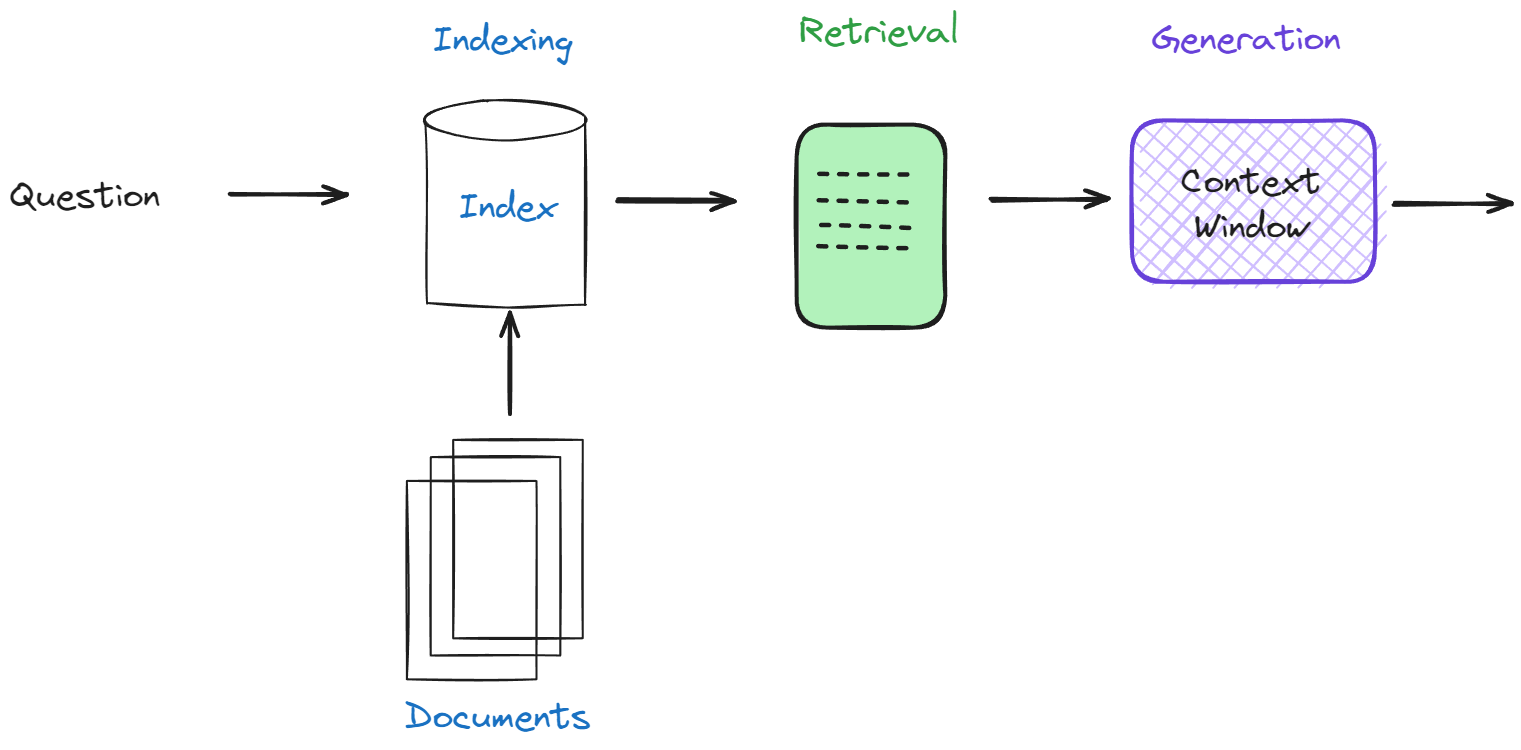

In [1]:
import sys
import os
import tqdm as notebook_tqdm
from typing import List

# Path to the directory containing config.py
config_path = '/home/mauricio/Documents/Projects/RAG-Mastery'

# Add the directory to sys.path
if config_path not in sys.path:
    sys.path.append(config_path)

# Now you can import the API_KEY from config.py
from config import API_KEY

path_to_docs = "/home/mauricio/Documents/Projects/RAG-Mastery/data"

Import the ChatMistralAI class from langchain. With this, we'll be able to use the AI model from Mistral. In our case, the 7x8b model will be enough for our RAG system. We initialize the model with our API key to access Mistral's services.

In [2]:
from langchain_mistralai.chat_models import ChatMistralAI
def get_llm_model(self):
        return ChatMistralAI(
            model_name="open-mixtral-8x22b", 
            mistral_api_key=self.API_KEY
        )

In the next part, we use an UnstructuredLoader due to the multiple advantages it provides, and later we plan to increase the capabilities of our RAG system with this. The main advantages are that it can handle multiple file formats (.docx, .pdf, .txt) with a single loader and it preserves the document structure. This provides better retention of the original document layout and structure, which can lead to more accurate and context-aware text extraction.


In [3]:
from langchain_unstructured import UnstructuredLoader
from langchain.schema.document import Document

def load_documents(folder_path):
    documents = []
    for file in os.listdir(folder_path):
        if file.endswith('.docx') or file.endswith('.pdf') or file.endswith('.txt'):
            loader = UnstructuredLoader(os.path.join(folder_path, file))
            documents.extend(loader.load())
        print("Document loaded lenght: ", len(documents))
    print("Documents loaded successfully ✅")
    print(documents[0].metadata.get("filename"))
    return documents

The RecursiveCharacterTextSplitter is ideal for documents with multiple images and text because it adaptively splits content using various separators, preserves context through chunk overlap, and maintains the logical flow of diverse document elements. This approach ensures that the relationship between text and image descriptions is retained, while creating manageable chunks for processing. The flexibility in chunk size and overlap allows for fine-tuning to balance context preservation with efficient processing, making it particularly effective for complex documents in a RAG system

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma


def split_documents(documents, chunk_size= 1000, chunk_overlap= 200):
        try:
            text_splitter: RecursiveCharacterTextSplitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=chunk_overlap,
                length_function=len,
                separators=["\n\n", "\n", " ", ""]
            )
            splits: List[Document] = text_splitter.split_documents(documents)
            print("Split document successfully ✅")
            print("Documents split: ", len(splits))
            return splits
        except Exception as e:
            print(f"Error splitting documents: {e}")
            raise


In [5]:
from langchain_mistralai import MistralAIEmbeddings

def create_embeddings(splits):
    try:
        embeddings = MistralAIEmbeddings(
            model="mistral-embed",
            mistral_api_key=API_KEY
            )
        vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)
        retriever = vectorstore.as_retriever(
            search_type="mmr"
        )

        print("Retriever succesfuly created ✅")
        return retriever
    except Exception as e:
        print(f"Error embeding/retrieving documents {e}")
        raise



Let's add a prompt template to help turn raw user information into a fomrat that the LLM can wotk with. In this case the user input is a raw message.

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot.")
])


TypeError: BaseModel.__init__() takes 1 positional argument but 2 were given

### Use the function

In [9]:
a = load_documents(path_to_docs)
b = split_documents(a)
c = create_embeddings(b)